# Imports

In [337]:
import pandas as pd
import numpy as np
import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [581]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, ElasticNet
from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

In [2]:
from fivestar.data import get_data
listings = get_data()

In [3]:
listings.reset_index(drop=True, inplace=True)

# Functions

## amenitiy functions

In [4]:
def decode_amenities(df):
    data = df   
    def str_to_list(strn):
        row_items = strn[1:-1].split(',')
        for key,item in enumerate(row_items):
            row_items[key] = item.strip('"').casefold()
        return row_items    
    return data[['amenities']].applymap(str_to_list)

def count_amenities(df):
    data = df
    amenities = decode_amenities(data)
    data['amenities_count'] = amenities.applymap(lambda x: len(x))
    return data[['amenities_count']]

def has_amenity(df, name, alias=None):
    data = df
    if not alias:
        alias = name
    amenities = decode_amenities(data)
    col_name = f'has_{alias}'
    amenities[col_name] = amenities[['amenities']].applymap(lambda x: 1 if name.casefold() in x else 0)
    return amenities[[col_name]]

def count_amenity(df, name):
    data = has_amenity(df, name)
    return int(data.sum())

def count_filterables(df, filterables):
    data = decode_amenities(df)
    def apply_count(amenities):
        count = 0
        for item in filterables:
            if isinstance(item, list):
                for x in item:
                    if x.casefold() in amenities:
                        count += 1
                        break
            else:
                if item.casefold() in amenities:
                    count += 1
        return count
    data['fitered_amenities_count'] = data.applymap(apply_count)
    return data[['fitered_amenities_count']]

def encode_filterables(df, filterables):
    data = decode_amenities(df)
    for item in filterables:
        if isinstance(item, list):
            data[''.join([i for i in item[0] if i.isalpha()])] = 0
        else:
            data[''.join([i for i in item if i.isalpha()])] = 0
    encoding = data.drop(columns='amenities').copy()
    for index,column in enumerate(encoding.columns):
        if isinstance(filterables[index], list):
            for item in filterables[index]:
                data[column] =  data[['amenities',column]].apply(
                    lambda x: 1 if item.casefold() in x['amenities'] else 1 if x[column] == 1 else 0,
                    axis=1)
        else:
            data[column] =  data[['amenities']].apply(lambda x: 1 if filterables[index].casefold() in x['amenities'] else 0, axis=1)
    return data.drop(columns='amenities')

## property/roomtype and cancelation policy

In [5]:
def recode_cancellation(data):
    
    def recode_cancel(n):
        if n in ('strict_14_with_grace_period','super_strict_30', 'super_strict_60', 'strict'):
            recode = 'strict'
        elif n in ('moderate','flexible'):
            recode = n
        else:   
            recode = 'Other'       
        return recode
    
    data['cancellation_policy'] = data['cancellation_policy'].map(recode_cancel)
    return data[['cancellation_policy']]

def recode_property_room_type(data):
    
    def recode_prop(n):
        if n in ('Apartment','House'):
            recode = n
        else:
            recode = 'Other'       
        return recode
    
    def recode_room(n):
        if n == 'Entire home/apt':
            recode = 'Entire'
        else:
            recode = 'Other'       
        return recode
    
    data['property_type'] = data['property_type'].map(recode_prop)
    data['room_type'] = data['room_type'].map(recode_room)
    return data[['property_type','room_type']]

In [6]:
def host_london_flag(data):
    data['host_london_flag'] = data['host_location'].str.contains('london', case=False, regex=True)
    return data[['host_london_flag']]


## price columns

In [7]:
def price_tonumerical(df, price_columns):
    '''This function takes as input a dataframe and a list of price column names and converts the columnns to
    floats'''
    for column in price_columns:
        df[[column]] = df[[column]].applymap(str_to_price)
    return df[price_columns]
def str_to_price(strn):
    '''The function converts a price entry from string to float and removes the $ character'''
    if type(strn)== str:
        return float(strn.strip('$').replace(',',''))
    return strn

def calc_price_columns(data, cleaning_ratio=True, deposit_ratio=True):
    def col_tonumerical(df, column):
        '''This function takes as input a dataframe and a column name and converts the columnn to
        floats'''
        df[[column]] = df[[column]].applymap(str_to_price)
        return df
    def calculate_cleaning_ratio(df):
        '''This function calculates the ratio of cleaning fee to the nightly price'''
        col_tonumerical(df, 'cleaning_fee')
        tmp = round(df['cleaning_fee']/df['price'],2)
        df['cleaning_ratio'] = tmp.map(lambda x: 0 if np.isinf(x) else x)
        return df
    def calculate_deposit_ratio(df):
        '''This function calculates the ratio of security deposit fee to the nightly price'''
        col_tonumerical(df, 'security_deposit')
        tmp = round(df['security_deposit']/df['price'],2)
        df['deposit_ratio'] = tmp.map(lambda x: 0 if np.isinf(x) else x)
        return df
    col_list = []
    col_tonumerical(data, 'price')
    if cleaning_ratio:
        data = calculate_cleaning_ratio(data)
        col_list.append('cleaning_ratio')
    if deposit_ratio:
        data = calculate_deposit_ratio(data)
        col_list.append('deposit_ratio')
    return data[col_list]
price_columns=['price', 'security_deposit', 'cleaning_fee', 'extra_people']

## Response rate

In [8]:
def response_rate(df):
    '''This function takes as input a dataframe and a list of price column names and converts the columnns to
    floats'''
    def str_to_time(strn):
        '''The function converts a price entry from string to float and removes the $ character'''
        if type(strn)== str:
            return float(strn.strip('%'))
        return strn
    for column in ['host_response_rate']:
        df[[column]] = df[[column]].applymap(str_to_time)
    return df[['host_response_rate']]

## Categoricals

In [397]:
def categoricals_convert(df, categorical_columns):
    '''This function takes as input a dataframe and a list of categorical (t/f) column names and converts the columnns to
    0/1'''
    
    for column in categorical_columns:
        listings[[column]]=listings[[column]].applymap(lambda x: 1 if x =='t' else (0 if (x == 'f') or np.isnan(x) else x))
    return df[categorical_columns]
categorical_columns=['instant_bookable', 'host_identity_verified', 'is_location_exact']

In [567]:
X_train[['is_location_exact']].value_counts()

is_location_exact
1                    25130
0                    13681
dtype: int64

## Mean house prices

In [10]:
def house_prices(data):
    house_price_dict = {k: v for k, v in zip(boroughs, prices)}
    data['mean_house_prices']= data['neighbourhood_cleansed'].map(house_price_dict)
    return data[['mean_house_prices']]

prices = [950760, 301518,667593,357779,578705,502623,1099876,399645,
         578110,463806,462820,614955,972231,683987,527206,387535,
         452272,507876,778290,2092485,573938,616126,475142,638519,
         409477,452437,819044,641210,402121,554009,459922,818443,1718124]

boroughs = ['City of London', 'Barking and Dagenham', 'Barnet', 'Bexley','Brent', 'Bromley', 'Camden', 
            'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey', 'Harrow',
            'Havering', 'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea', 'Kingston upon Thames',
            'Lambeth', 'Lewisham', 'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames', 'Southwark', 
            'Sutton', 'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster']

In [534]:
def price_to_mean_ratio(df):
    data = df[['price']].join(house_prices(df))
    data['price'] = price_tonumerical(listings, ['price'])
    data['price_ratio'] = (data['price'] / (data['mean_house_prices'] / 1e5)**2)
    median = data['price_ratio'].median()
    data['price_ratio'] = data['price_ratio'].map(lambda x: x if x > 0 else median)
#     scaler = StandardScaler()
#     data['price_ratio'] = scaler.fit_transform(data[['price_ratio']])
    data['price_ratio'] = np.log(data['price_ratio'])
    return data[['price_ratio']]


## Room/bed number ratios

In [11]:
def get_room_ratios(df):
    data = df
    data['accommodates_to_rooms_ratio'] = data['accommodates'] / data['bedrooms'].map(lambda x: 1 if x == 0 else x)
#     data['accommodates_to_rooms_ratio'] = data[['accommodates_to_rooms_ratio']]
    return data[['accommodates_to_rooms_ratio']]

## Availablity

In [12]:
def availability(df):
    data=df['availability_365']
    data[data=='f']='NaN'
    out = pd.DataFrame(data.astype(float))
    return out

## Cleanliness

In [653]:
def cleanliness_delta(df):
    data = df
    data[['cleanliness_delta']] = listings['review_scores_cleanliness']\
                                - listings[['review_scores_checkin',
                                            'review_scores_accuracy',
                                            'review_scores_cleanliness',
                                            'review_scores_communication',
                                            'review_scores_location',
                                            'review_scores_value'
                                           ]].mean(axis=1)
    return data[['cleanliness_delta']].applymap(lambda x: 0.0 if np.isnan(x) else x)

def score_delta(df, score_column):
    data = df
    col_name = score_column[14:] + '_score_delta'
    data[[col_name]] = listings[score_column]\
                                - listings[['review_scores_checkin',
                                            'review_scores_accuracy',
                                            'review_scores_cleanliness',
                                            'review_scores_communication',
                                            'review_scores_location',
                                            'review_scores_value'
                                           ]].mean(axis=1)
    return data[[col_name]].applymap(lambda x: 0.0 if np.isnan(x) else x)

# First df of chosen features

In [66]:
categorical_columns=['instant_bookable', 'host_identity_verified', 'is_location_exact']

features = [['Free parking on premises', 'free street parking', 'paid parking on premises' ,'paid parking off premises'],
            'Dryer','Wifi','Breakfast',
            'Indoor fireplace','Hangers','Iron','Hair dryer',['Dedicated workspace','laptop friendly workspace'],
            ['TV', 'cable tv'],
            ['Smoke alarm','Smoke detector'],['Carbon monoxide alarm','carbon monoxide detector']]

data = listings[['review_scores_rating']].copy()\
            .join(categoricals_convert(listings, categorical_columns))\
            .join(house_prices(listings))\
            .join(count_amenities(listings))\
            .join(encode_filterables(listings, features))\
            .join(listings[['host_listings_count']])\
            .join(recode_property_room_type(listings))\
            .join(recode_cancellation(listings))\
            .join(response_rate(listings))\
            .join(price_tonumerical(listings, ['price']))\
            .join(get_room_ratios(listings))\
            .join(calc_price_columns(listings))



In [140]:
data.head()

,review_scores_rating,instant_bookable,host_identity_verified,is_location_exact,mean_house_prices,amenities_count,Freeparkingonpremises,Dryer,Wifi,Breakfast,Indoorfireplace,TV,Smokealarm,host_listings_count,cancellation_policy,host_response_rate,accommodates_to_rooms_ratio
0,92.0,1,1.0,1,616126,22,1,0,1,0,0,1,1,3.0,strict,100.0,4.0
1,97.0,0,1.0,1,778290,45,1,1,1,0,0,1,1,4.0,moderate,70.0,2.0
2,96.0,1,1.0,1,2092485,30,0,1,1,0,0,1,1,1.0,strict,100.0,2.0
3,94.0,1,1.0,1,1718124,30,1,1,1,0,0,1,1,18.0,strict,100.0,2.0
4,93.0,1,0.0,1,818443,24,1,0,1,0,0,1,1,1.0,moderate,100.0,2.0


# Scaler to look at correlations more carefully

In [141]:
from sklearn.preprocessing import StandardScaler

# data = data.dropna()

X = data.drop(columns=['review_scores_rating']).copy()
y = data['review_scores_rating'].copy()

X_d = pd.get_dummies(X)

to_drop = ['cancellation_policy_moderate','cancellation_policy_flexible']
X_d.drop(columns=to_drop, inplace=True)

scaler = StandardScaler()
X_s = pd.DataFrame(scaler.fit_transform(X_d), columns=X_d.columns)

In [142]:
Y = pd.DataFrame(y)

In [143]:
temp2 = listings[['review_scores_rating']].join(X_s).corr()#['review_scores_rating']
path = '../data/correlations2.csv'
temp2.to_csv(path)

In [144]:
X_s.shape

(51749, 16)

In [145]:
path = '../data/correlations.csv'
# temp.to_csv(path)

In [146]:
listings[['room_type']].value_counts()

room_type
Other        51749
dtype: int64

In [147]:
listings[['property_type']].value_counts()

property_type
Apartment        35550
House             9764
Other             6435
dtype: int64

# First linear model

In [354]:
features = [['Free parking on premises', 'free street parking', 'paid parking on premises' ,'paid parking off premises'],
            'Dryer','Wifi','Breakfast',
            'Indoor fireplace',
            ['TV', 'cable tv'],
            ['Smoke alarm','Smoke detector']]

data = listings[['review_scores_rating']].copy()\
            .join(categoricals_convert(listings, categorical_columns))\
            .join(house_prices(listings))\
            .join(count_amenities(listings))\
            .join(encode_filterables(listings, features))\
            .join(listings[['host_listings_count','review_scores_cleanliness']])\
            .join(recode_cancellation(listings))\
            .join(response_rate(listings))\
            .join(get_room_ratios(listings))

In [166]:
X = data.drop(columns=['review_scores_rating']).copy()
y = data['review_scores_rating'].copy()

X_d = pd.get_dummies(X)
to_drop = ['cancellation_policy_moderate','cancellation_policy_flexible']
X_d.drop(columns=to_drop, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X_d, y, random_state=42)

In [167]:
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

X_train_i = imputer.fit_transform(X_train)
X_test_i = imputer.transform(X_test)

X_train_s = scaler.fit_transform(X_train_i)
X_test_s = scaler.transform(X_test_i)

In [168]:
def match_coeffs(model, X_train):
    coefs = pd.DataFrame.from_dict(dict(
        column = X_train.columns,
        coef = model.coef_
        ))
    return coefs
#     coefs = {}
#     for col, coeff in zip(X_train.columns, model.coef_):
#         coefs[col] = coeff

In [169]:
model = LinearRegression()
lasso = Lasso(alpha=0.5)
ridge = Ridge(alpha=2)

model.fit(X_train_s, y_train)
lasso.fit(X_train_s, y_train)
ridge.fit(X_train_s, y_train)

Ridge(alpha=2)

In [170]:
model.score(X_test_s, y_test), lasso.score(X_test_s, y_test), ridge.score(X_test_s, y_test)

(0.5635089845874328, 0.5386654688636857, 0.5635090627230263)

## coefficients

In [172]:
lasso.coef_

array([-0.22337712,  0.        ,  0.        , -0.09599342,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  4.88923861,  0.        ,
       -0.1172272 , -0.        ])

In [173]:
ridge.coef_

array([-0.54650172,  0.32452752,  0.14778484, -0.43876708,  0.17047935,
        0.13662435,  0.18511807,  0.21184846,  0.21427411,  0.17797246,
        0.04351501,  0.06258744, -0.30047247,  5.12476829,  0.12251611,
       -0.46542011, -0.34885797])

In [174]:
type(X_train_i), type(X_train_s)

(numpy.ndarray, numpy.ndarray)

In [175]:
match_coeffs(model, X_train).sort_values('coef', ascending=False)

,column,coef
13,review_scores_cleanliness,5.125043
1,host_identity_verified,0.324527
8,Breakfast,0.214265
7,Wifi,0.211849
6,Dryer,0.185120
9,Indoorfireplace,0.177977
4,amenities_count,0.170459
2,is_location_exact,0.147783
5,Freeparkingonpremises,0.136607
14,host_response_rate,0.122504


In [176]:
match_coeffs(lasso, X_train).sort_values('coef', ascending=False)

,column,coef
13,review_scores_cleanliness,4.889239
8,Breakfast,0.000000
1,host_identity_verified,0.000000
14,host_response_rate,0.000000
12,host_listings_count,-0.000000
11,Smokealarm,0.000000
10,TV,0.000000
9,Indoorfireplace,0.000000
16,cancellation_policy_strict,-0.000000
7,Wifi,0.000000


In [177]:
match_coeffs(ridge, X_train).sort_values('coef', ascending=False)

,column,coef
13,review_scores_cleanliness,5.124768
1,host_identity_verified,0.324528
8,Breakfast,0.214274
7,Wifi,0.211848
6,Dryer,0.185118
9,Indoorfireplace,0.177972
4,amenities_count,0.170479
2,is_location_exact,0.147785
5,Freeparkingonpremises,0.136624
14,host_response_rate,0.122516


In [178]:
y_pred = model.predict(X_test_s)

In [179]:
r2_score(y_test, y_pred, sample_weight=None, multioutput='uniform_average')

0.5635089845874328

In [180]:
permutation_score = permutation_importance(model, X_train_s, y_train, n_repeats=100)
# np.vstack((X_train.columns, permutation_score.importances_mean)).T

perm_scores = pd.DataFrame.from_dict(dict(column=X_train.columns, score=permutation_score.importances_mean))

In [181]:
perm_scores.sort_values('score', ascending=False)

,column,score
13,review_scores_cleanliness,0.954854
0,instant_bookable,0.010796
15,accommodates_to_rooms_ratio,0.007904
3,mean_house_prices,0.006959
16,cancellation_policy_strict,0.004502
1,host_identity_verified,0.003842
12,host_listings_count,0.003296
8,Breakfast,0.001689
7,Wifi,0.001619
6,Dryer,0.001226


## p-values

In [171]:
X2 = sm.add_constant(X_train_s)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                             OLS Regression Results                             
Dep. Variable:     review_scores_rating   R-squared:                       0.568
Model:                              OLS   Adj. R-squared:                  0.568
Method:                   Least Squares   F-statistic:                     2998.
Date:                  Thu, 26 Nov 2020   Prob (F-statistic):               0.00
Time:                          15:30:06   Log-Likelihood:            -1.1659e+05
No. Observations:                 38811   AIC:                         2.332e+05
Df Residuals:                     38793   BIC:                         2.334e+05
Df Model:                            17                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         92.9604      0.025

# Clustering

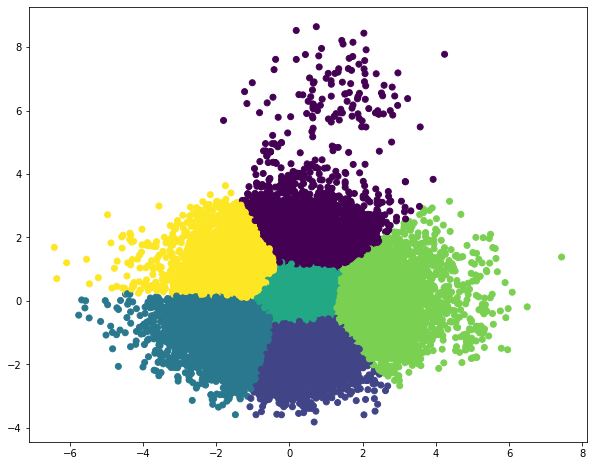

In [233]:
plt.figure(figsize=(10, 8))

pca = PCA(n_components=2)
X_p = pca.fit_transform(X_train_s)

km = KMeans(n_clusters=6, random_state=42)
y_pred = km.fit_predict(X_p)
plt.scatter(X_p[:,0], X_p[:,1], c=y_pred, label='cluster')
# plt.legend([X_p[:,0], X_p[:,1]], [0,1])

In [234]:
X_train['cluster'] = y_pred

/Users/ed/.pyenv/versions/3.7.7/envs/5-star/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [235]:
temp = X_train[['cluster']].join(y_train)

In [236]:
temp.groupby('cluster').mean().sort_values('review_scores_rating', ascending=False)

,review_scores_rating
cluster,
2,96.576050
1,95.694167
5,93.593176
3,92.758996
4,88.508219
0,87.083391


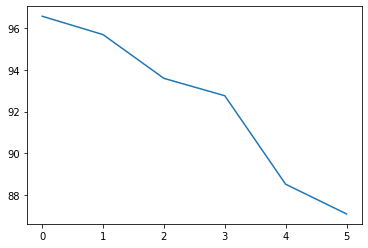

In [237]:
plt.plot(temp.groupby('cluster').mean().sort_values('review_scores_rating', ascending=False).reset_index(drop=True))

In [238]:
pd.DataFrame.from_dict(dict(pca.components_))

ValueError: dictionary update sequence element #0 has length 17; 2 is required

/Users/ed/.pyenv/versions/3.7.7/envs/5-star/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

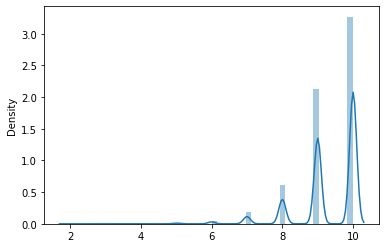

In [232]:
sns.distplot(listings[['review_scores_cleanliness']])

In [292]:
import hdbscan

clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=50, 
    metric='euclidean', min_cluster_size=35, min_samples=None, p=None)

clusterer.fit(X_p)

HDBSCAN(leaf_size=50, min_cluster_size=35)

In [293]:
clusterer.labels_.max()

3

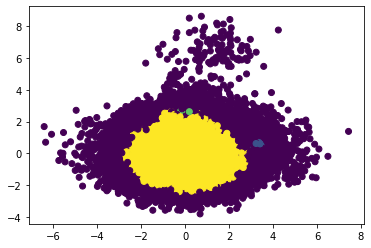

In [294]:
plt.scatter(X_p[:,0], X_p[:,1], c=clusterer.labels_, label='cluster')

# Extra Feature exploration/engineering

## Cleanliness feature - delta from other review scores

<AxesSubplot:ylabel='Count'>

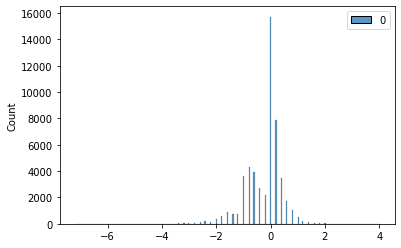

In [501]:
sns.histplot(pd.DataFrame(listings['review_scores_cleanliness'] - listings[['review_scores_checkin','review_scores_accuracy','review_scores_checkin','review_scores_location','review_scores_value']].mean(axis=1)))

<AxesSubplot:>

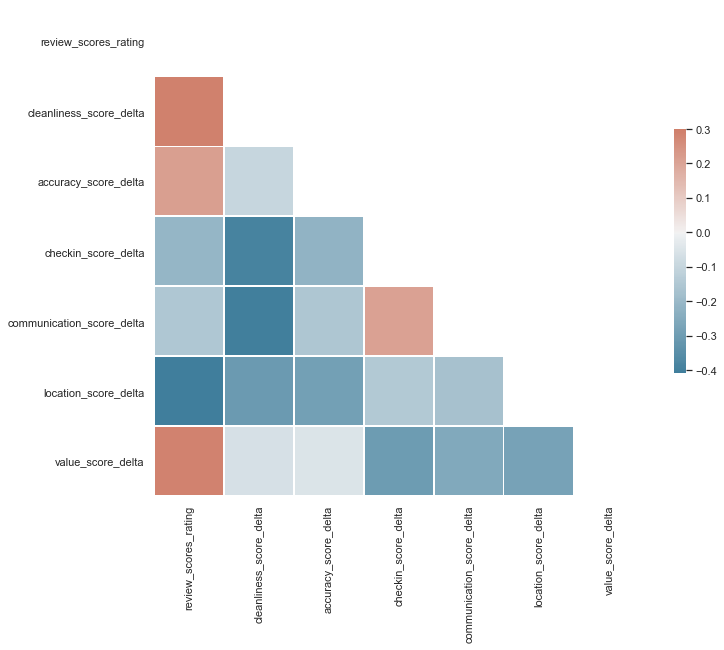

In [660]:
temp = listings[['review_scores_rating']].copy()
sns.set_theme(style="white")


corr = temp.join(score_delta(listings, 'review_scores_cleanliness'))\
                                      .join(score_delta(listings, 'review_scores_accuracy'))\
                                      .join(score_delta(listings, 'review_scores_checkin'))\
                                      .join(score_delta(listings, 'review_scores_communication'))\
                                      .join(score_delta(listings, 'review_scores_location'))\
                                      .join(score_delta(listings, 'review_scores_value'))\
                                      .corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## price / housing prices ratio

,review_scores_rating,price,mean_house_prices,price_ratio
review_scores_rating,1.000000,-0.022731,-0.118783,0.104180
price,-0.022731,1.000000,0.233238,0.265713
mean_house_prices,-0.118783,0.233238,1.000000,-0.696086
price_ratio,0.104180,0.265713,-0.696086,1.000000


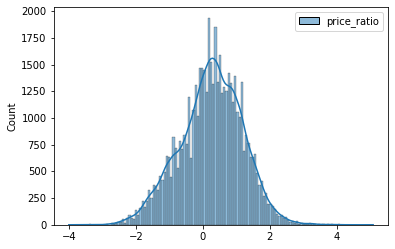

In [535]:
    
listings[['price']].describe()
temp = price_tonumerical(listings, ['price'])
temp[temp['price'] == 0.0].count()
temp = price_to_mean_ratio(listings)
# temp = temp[temp['price_ratio'] > 0]
sns.histplot(temp,kde=True)
listings[['review_scores_rating','price']].join(house_prices(listings)).join(price_to_mean_ratio(listings)).corr()

# Linear model iteration

## Basic linear model with 2 new features

In [662]:
listings = get_data()
listings.reset_index(drop=True, inplace=True)

In [663]:
amenities = [['Free parking on premises', 'free street parking', 
              'paid parking on premises' ,'paid parking off premises'],
            'Dryer','Wifi','Breakfast',
            'Indoor fireplace',
            ['TV', 'cable tv'],
            ['Smoke alarm','Smoke detector']]

categorical_columns=['instant_bookable', 'host_identity_verified', 'is_location_exact']

data = listings[['review_scores_rating']].copy()\
            .join(categoricals_convert(listings, categorical_columns))\
            .join(price_to_mean_ratio(listings))\
            .join(count_amenities(listings))\
            .join(encode_filterables(listings, features))\
            .join(listings[['host_listings_count']])\
            .join(recode_cancellation(listings))\
            .join(response_rate(listings))\
            .join(get_room_ratios(listings))\
            .join(cleanliness_delta(listings))\
            .join(recode_property_room_type(listings))

In [664]:
X = data.drop(columns=['review_scores_rating']).copy()
y = data['review_scores_rating'].copy()

X_d = pd.get_dummies(X)
to_drop = ['cancellation_policy_moderate','cancellation_policy_flexible','room_type_Other',
           'property_type_Apartment','property_type_House','property_type_Other']
X_d.drop(columns=to_drop, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X_d, y, random_state=42)

In [665]:
scaler = StandardScaler()
imputer = SimpleImputer(strategy='median')
# Impute: 'host_response_rate': median 'host_listings_count': 1 'accommodates_to_rooms_ratio': mean

X_train_i = imputer.fit_transform(X_train)
X_test_i = imputer.transform(X_test)

X_train_s = scaler.fit_transform(X_train_i)
X_test_s = scaler.transform(X_test_i)

In [666]:
model = LinearRegression()
model.fit(X_train_s, y_train)
model.score(X_test_s, y_test), model.score(X_train_s, y_train)

(0.18259168416141636, 0.19674988048016884)

In [667]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38811 entries, 11225 to 15795
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   instant_bookable             38811 non-null  int64  
 1   host_identity_verified       38811 non-null  int64  
 2   is_location_exact            38811 non-null  int64  
 3   price_ratio                  38811 non-null  float64
 4   amenities_count              38811 non-null  int64  
 5   Freeparkingonpremises        38811 non-null  int64  
 6   Dryer                        38811 non-null  int64  
 7   Wifi                         38811 non-null  int64  
 8   Breakfast                    38811 non-null  int64  
 9   Indoorfireplace              38811 non-null  int64  
 10  TV                           38811 non-null  int64  
 11  Smokealarm                   38811 non-null  int64  
 12  host_listings_count          38733 non-null  float64
 13  host_respons

In [668]:
match_coeffs(model, X_train).sort_values('coef')

,column,coef
0,instant_bookable,-1.025367
14,accommodates_to_rooms_ratio,-0.887745
16,cancellation_policy_strict,-0.510433
12,host_listings_count,-0.461569
17,room_type_Entire,-0.425501
10,TV,0.168881
9,Indoorfireplace,0.185292
6,Dryer,0.247198
11,Smokealarm,0.272929
2,is_location_exact,0.288300


In [551]:
X2 = sm.add_constant(X_train_s)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                             OLS Regression Results                             
Dep. Variable:     review_scores_rating   R-squared:                       0.199
Model:                              OLS   Adj. R-squared:                  0.198
Method:                   Least Squares   F-statistic:                     534.0
Date:                  Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                          14:14:46   Log-Likelihood:            -1.2857e+05
No. Observations:                 38811   AIC:                         2.572e+05
Df Residuals:                     38792   BIC:                         2.573e+05
Df Model:                            18                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         92.9604      0.034

In [553]:
X_train.columns.tolist()

['instant_bookable',
 'host_identity_verified',
 'is_location_exact',
 'price_ratio',
 'amenities_count',
 'Freeparkingonpremises',
 'Dryer',
 'Wifi',
 'Breakfast',
 'Indoorfireplace',
 'TV',
 'Smokealarm',
 'host_listings_count',
 'host_response_rate',
 'accommodates_to_rooms_ratio',
 'cleanliness_delta',
 'cancellation_policy_strict',
 'room_type_Entire']

## Hyperparameters

### setup

In [703]:
listings = get_data()
listings.reset_index(drop=True, inplace=True)

amenities = [['Free parking on premises', 'free street parking', 
              'paid parking on premises' ,'paid parking off premises'],
            'Dryer','Wifi','Breakfast',
            'Indoor fireplace',
            ['TV', 'cable tv'],
            ['Smoke alarm','Smoke detector']]

categorical_columns=['instant_bookable', 'host_identity_verified', 'is_location_exact']

data = listings[['review_scores_rating']].copy()\
            .join(categoricals_convert(listings, categorical_columns))\
            .join(price_to_mean_ratio(listings))\
            .join(count_amenities(listings))\
            .join(encode_filterables(listings, amenities))\
            .join(listings[['host_listings_count']])\
            .join(recode_cancellation(listings))\
            .join(response_rate(listings))\
            .join(get_room_ratios(listings))\
            .join(cleanliness_delta(listings))\
            .join(recode_property_room_type(listings))

X = data.drop(columns=['review_scores_rating']).copy()
y = data['review_scores_rating'].copy()

X_d = pd.get_dummies(X)
to_drop = ['cancellation_policy_moderate','cancellation_policy_flexible','room_type_Other',
           'property_type_Apartment','property_type_House','property_type_Other']
X_d.drop(columns=to_drop, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X_d, y, random_state=42)

In [704]:
to_impute = ['host_response_rate','accommodates_to_rooms_ratio']
to_scale = []
# scaler = ColumnTransformer([('imputer', StandardScaler(), to_scale)], remainder='passthrough')
scaler = StandardScaler()
imputer = SimpleImputer(strategy='median')
# imputer = ColumnTransformer([
#     ('imputer', SimpleImputer(strategy='median'), to_impute),
#     ('constant', SimpleImputer(strategy='constant', fill_value=1), ['host_listings_count']),
#     ], remainder='passthrough')
# Impute: 'host_response_rate': median 'host_listings_count': 1 'accommodates_to_rooms_ratio': mean

X_train_i = imputer.fit_transform(X_train)
X_test_i = imputer.transform(X_test)

X_train_s = scaler.fit_transform(X_train_i)
X_test_s = scaler.transform(X_test_i)

### Ridge

In [705]:
model = Ridge()
model.fit(X_train_s, y_train)
model.score(X_test_s, y_test), model.score(X_train_s, y_train)

(0.18259198751182726, 0.1967498804015806)

In [706]:
params = dict(
    alpha = stats.loguniform(1,1000),
    )

ridge_grid = RandomizedSearchCV(Ridge(), param_distributions=params, n_jobs=-1, n_iter=1000)
history = ridge_grid.fit(X_train_s, y_train)

In [707]:
ridge_grid.score(X_test_s, y_test)

0.18266100624214843

In [708]:
ridge_grid.best_score_, ridge_grid.best_params_

(0.19542855653386845, {'alpha': 245.50435194240978})

In [709]:
0.1873/0.1970

0.9507614213197969

#### coefs
Best so far is Ridge reggression with alpha = 243.19667039655616

In [710]:
ridge_model = ridge_grid.best_estimator_

In [711]:
match_coeffs(ridge_model, X_train).sort_values('coef', ascending=False)

,column,coef
15,cleanliness_delta,1.923882
3,price_ratio,0.571376
1,host_identity_verified,0.552635
4,amenities_count,0.517618
13,host_response_rate,0.489294
8,Breakfast,0.426015
5,Freeparkingonpremises,0.355324
7,Wifi,0.341622
2,is_location_exact,0.286965
11,Smokealarm,0.273097


In [713]:
permutation_score = permutation_importance(ridge_model, X_train_s, y_train, n_repeats=100)
perm_scores = pd.DataFrame.from_dict(dict(column=X_train.columns, score=permutation_score.importances_mean))
perm_scores.sort_values('score', ascending=False)

,column,score
15,cleanliness_delta,0.135179
0,instant_bookable,0.037979
14,accommodates_to_rooms_ratio,0.028662
3,price_ratio,0.011873
1,host_identity_verified,0.011167
4,amenities_count,0.009769
16,cancellation_policy_strict,0.009445
13,host_response_rate,0.008760
12,host_listings_count,0.007702
8,Breakfast,0.006626


### Elastic Net

In [615]:
params = dict(
    alpha = stats.loguniform(0.1,500),
    l1_ratio = stats.uniform(0,1)
    )

grid = RandomizedSearchCV(ElasticNet(), param_distributions=params, n_jobs=-1, n_iter=1000)
history = grid.fit(X_train_s, y_train)

In [616]:
grid.best_score_, grid.best_params_

(0.19623769060106136,
 {'alpha': 0.10548108041305748, 'l1_ratio': 0.1354324405908336})

In [617]:
grid.score(X_test_s, y_test)

0.18699868282699905

In [618]:
match_coeffs(grid.best_estimator_, X_train)

,column,coef
0,instant_bookable,-0.943183
1,host_identity_verified,0.512456
2,is_location_exact,0.262745
3,price_ratio,0.512090
4,amenities_count,0.491522
5,Freeparkingonpremises,0.360169
6,Dryer,0.230261
7,Wifi,0.315977
8,Breakfast,0.405305
9,Indoorfireplace,0.178378


### Lasso

In [632]:
params = dict(
    alpha = [0.3] #stats.loguniform(0.001,10),
#     l1_ratio = stats.uniform(0,1)
    )

grid = RandomizedSearchCV(Lasso(), param_distributions=params, n_jobs=-1, n_iter=1)
history = grid.fit(X_train_s, y_train)

In [633]:
grid.best_score_, grid.best_params_

(0.1777564507853949, {'alpha': 0.3})

In [634]:
grid.score(X_test_s, y_test)

0.1713905378065912

In [635]:
match_coeffs(grid.best_estimator_, X_train)

,column,coef
0,instant_bookable,-0.806748
1,host_identity_verified,0.342720
2,is_location_exact,0.045082
3,price_ratio,0.240665
4,amenities_count,0.479359
5,Freeparkingonpremises,0.293889
6,Dryer,0.000000
7,Wifi,0.133238
8,Breakfast,0.291657
9,Indoorfireplace,0.000000


## Cut lowest features

### Setup

In [692]:
listings = get_data()
listings.reset_index(drop=True, inplace=True)

amenities = [['Free parking on premises', 'free street parking', 
              'paid parking on premises' ,'paid parking off premises'],
#              'Dryer',
             'Wifi','Breakfast',
#             'Indoor fireplace',
#             ['TV', 'cable tv'],
#             ['Smoke alarm','Smoke detector']]
            ]

categorical_columns=['instant_bookable', 'host_identity_verified', 'is_location_exact']

data = listings[['review_scores_rating']].copy()\
            .join(categoricals_convert(listings, categorical_columns))\
            .join(price_to_mean_ratio(listings))\
            .join(count_amenities(listings))\
            .join(encode_filterables(listings, amenities))\
            .join(listings[['host_listings_count']])\
            .join(recode_cancellation(listings))\
            .join(response_rate(listings))\
            .join(get_room_ratios(listings))\
            .join(cleanliness_delta(listings))\
            .join(recode_property_room_type(listings))

X = data.drop(columns=['review_scores_rating']).copy()
y = data['review_scores_rating'].copy()

X_d = pd.get_dummies(X)
to_drop = ['cancellation_policy_moderate','cancellation_policy_flexible','room_type_Other',
           'property_type_Apartment','property_type_House','property_type_Other']
X_d.drop(columns=to_drop, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X_d, y, random_state=42)

In [693]:
to_impute = ['host_response_rate','accommodates_to_rooms_ratio']
to_scale = []
# scaler = ColumnTransformer([('imputer', StandardScaler(), to_scale)], remainder='passthrough')
scaler = StandardScaler()
imputer = SimpleImputer(strategy='median')
# imputer = ColumnTransformer([
#     ('imputer', SimpleImputer(strategy='median'), to_impute),
#     ('constant', SimpleImputer(strategy='constant', fill_value=1), ['host_listings_count']),
#     ], remainder='passthrough')
# Impute: 'host_response_rate': median 'host_listings_count': 1 'accommodates_to_rooms_ratio': mean

X_train_i = imputer.fit_transform(X_train)
X_test_i = imputer.transform(X_test)

X_train_s = scaler.fit_transform(X_train_i)
X_test_s = scaler.transform(X_test_i)

### Ridge model

In [694]:
model2 = Ridge(alpha=50)
model2.fit(X_train_s, y_train)
model2.score(X_test_s, y_test), model2.score(X_train_s, y_train)

(0.17897549674129343, 0.19332629399434265)

In [696]:
params = dict(
    alpha = stats.loguniform(1,1000),
    )

ridge_grid2 = RandomizedSearchCV(Ridge(), param_distributions=params, n_jobs=-1, n_iter=1000)
history2 = ridge_grid2.fit(X_train_s, y_train)
ridge_grid2.score(X_test_s, y_test)

0.1790222885077094

In [697]:
ridge_grid2.best_score_, ridge_grid2.best_params_

(0.19213459397123758, {'alpha': 213.31262934055124})

In [688]:
match_coeffs(model2, X_train).sort_values('coef')

,column,coef
0,instant_bookable,-1.039968
10,accommodates_to_rooms_ratio,-0.899409
12,cancellation_policy_strict,-0.522933
8,host_listings_count,-0.469388
13,room_type_Entire,-0.333703
2,is_location_exact,0.305936
5,Freeparkingonpremises,0.341552
6,Wifi,0.367711
7,Breakfast,0.445746
9,host_response_rate,0.488550


#### OLS summary

In [689]:
X2 = sm.add_constant(X_train_s)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                             OLS Regression Results                             
Dep. Variable:     review_scores_rating   R-squared:                       0.193
Model:                              OLS   Adj. R-squared:                  0.193
Method:                   Least Squares   F-statistic:                     664.1
Date:                  Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                          16:55:10   Log-Likelihood:            -1.2870e+05
No. Observations:                 38811   AIC:                         2.574e+05
Df Residuals:                     38796   BIC:                         2.575e+05
Df Model:                            14                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         92.9604      0.034

# Pipeline

In [ ]:
def make_pipeline()
    
    
    
    processing = ColumnTransformer()